# A demonstration of oslo_method_python


Before this notebook is run on a new system, make sure to compile the Cython files by doing (in the top repo directory):

```python setup.py build_ext --inplace```

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget
# %matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import ompy as om
import logging
import pickle

In [2]:
# Import raw matrix into instance of om.Matrix() and plot it
# raw = om.Matrix()
# raw.load('data/alfna')
# raw.cut_diagonal((800, 0), (7500, 7300))
# raw.cut(axis='Ex', limits=[0, 6500])
# raw.plot()

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("ompy.unfolder")
logger.setLevel(logging.INFO)

# fname_resp_mat = "data/response_matrix.m"
# fname_resp_dat = "data/response_parameters.dat"

# unfolder = om.Unfolder()
# unfolder.load_response(fname_resp_mat)
# unfolded = unfolder.unfold(raw)
# unfolded.plot()

In [4]:
# firstgen = om.first_generation_method(unfolded, Ex_max=6500, dE_gamma=500)
# firstgen.plot(zmin=1e-3)

In [5]:
# # Do error propagation in order to obtain an error matrix on the first generation spectrum
# # Note that it requires an instance of MatrixAnalysis as input
# logger = logging.getLogger("ompy.ensemble")
# logger.setLevel(logging.INFO)

# unfolder = om.Unfolder()
# unfolder.cut_diagonal((800, 0), (7500, 7300))
# unfolder.load_response(fname_resp_mat)
# unfolded = unfolder.unfold(raw)

# N_ensemble = 100

# def firstmethod(U):
#     return om.first_generation_method(matrix_in=U, Ex_max=6500,
#                                      dE_gamma=800,multiplicity_estimation="statistical")

# ensemble = om.Ensemble(raw=raw)
# ensemble.unfolder = unfolder
# ensemble.first_generation_method = firstmethod
# ensemble.generate(number=N_ensemble, regenerate=True)


In [6]:
# fig, ax = plt.subplots(ncols=3, sharey=True)
# ensemble.std_raw.plot(ax=ax[0])
# ensemble.std_unfolded.plot(ax=ax[1])
# ensemble.std_firstgen.plot(ax=ax[2])
# plt.tight_layout()
# plt.show()

In [7]:
firstgen = om.Matrix()
firstgen.load("1Gen_popall.m")
firstgen.cut_diagonal((800, 0), (7500, 7300))
firstgen.cut(axis='Ex', limits=[0, 8400])
firstgen.plot()

<IPython.core.display.Javascript object>

In [8]:
N_ensemble = 20

ensemble = np.zeros((N_ensemble, *firstgen.shape))
std = np.where(firstgen.values > 0, firstgen.values, 0)
for i in range(N_ensemble):
    perturbed = np.random.poisson(std)
    ensemble[i, :, :] = perturbed
    
# ensembleAll = np.zeros((N_ensemble, *firstgenAll.shape))
# stdAll = np.where(firstgenAll.values > 0, firstgenAll.values, 0)
# for i in range(N_ensemble):
#     perturbed = np.random.poisson(stdAll)
#     ensembleAll[i, :, :] = perturbed

In [9]:
# bin_width_out = 120#150
# Ex_min = 3000
# Ex_max = 6500
# Eg_min = 1000

# ftol = 1e-3 # Fitting tolerance (in some unknown, relative units)
# maxfev = None # maximum number of function evaluations

bin_width_out = 150
Ex_min = 4000
Ex_max = 7800
Eg_min = 1000

ftol = 1e-4 # Fitting tolerance (in some unknown, relative units)
maxfev = 9000 # maximum number of function evaluations

N_fits = 20#N_ensemble

In [10]:
# std = ensemble.std_firstgen
mat = om.Matrix(ensemble[0],
                     Ex=firstgen.Ex,
                     Eg=firstgen.Eg)
fits = om.FitRhoT(mat, std, bin_width_out,
                      Ex_min, Ex_max, Eg_min,
                      method="Powell",
                      options={'disp':True, 'ftol':ftol, 'maxfev':maxfev}
                      #error_normalization="approximate"
                     )
fits.fit()
rho = fits.rho
T = fits.T

attempt decomposition
Optimization terminated successfully.
         Current function value: 437443.718750
         Iterations: 6
         Function evaluations: 8944


In [11]:
# Decomposition with the new 1Gen matrixes -- if saved, just load them again

rho_ens = []
gsf_ens = []

add_string = "-2"

try:
#     nld_Earray = np.loadtxt("error_propagation_ensemble/rho_E_array.txt")
#     gsf_Earray = np.loadtxt("error_propagation_ensemble/gsf_E_array.txt")
#     rho_val = np.loadtxt("error_propagation_ensemble/rho_ensemble_fits-{:d}-bin_width_{:d}.txt".format(N_fits, bin_width_out))
#     gsf_val = np.loadtxt("error_propagation_ensemble/T_ensemble_fits-{:d}-bin_width_{:d}.txt".format(N_fits, bin_width_out))
#     print(rho_val)
    for i in range(N_fits):
        rho_val = np.loadtxt("error_propagation_ensemble/rho_ensemble_fits" + add_string + "-{:d}-bin_width_{:d}.txt".format(i, bin_width_out))
        gsf_val = np.loadtxt("error_propagation_ensemble/gsf_ensemble_fits" + add_string + "-{:d}-bin_width_{:d}.txt".format(i, bin_width_out))
    #         gsf_val[i,:] /= T.E**3
        rho_tmp = om.Vector(rho_val, rho.E)
        rho_ens.append(rho_tmp)
        gsf_tmp = om.Vector(gsf_val, T.E)
        gsf_ens.append(gsf_tmp)
except:
#     std = ensemble.std_firstgen
    for i in range(N_fits):
        print("Start of iteration {}".format(i))
        mat = om.Matrix(ensemble[i],
                     Ex=firstgen.Ex,
                     Eg=firstgen.Eg)
        if i!=0:
            p0 = np.append(p0_rho.values, p0_T.values)
            print("Taking old result as p0")
        else:
            p0 = None
        fits = om.FitRhoT(mat, std, bin_width_out,
                              Ex_min, Ex_max, Eg_min,
                              method="Powell",
                              options={'disp':True, 'ftol':ftol, 'maxfev':maxfev}
                              #error_normalization="approximate"
                             )
        fits.fit(p0=p0)
        rho_ens.append(fits.rho)
        T = fits.T
        gsf = T.values / (2 * np.pi * (T.E)**3)
        gsf_ens.append(om.Vector(gsf,T.E))

        if i==0:
            p0_rho = fits.rho
            p0_T = fits.T
        np.savetxt("error_propagation_ensemble/rho_ensemble_fits" + add_string + "-{:d}-bin_width_{:d}.txt".format(i, bin_width_out), rho_ens[i].values)
        np.savetxt("error_propagation_ensemble/gsf_ensemble_fits" + add_string + "-{:d}-bin_width_{:d}.txt".format(i, bin_width_out), gsf_ens[i].values)

    np.savetxt("error_propagation_ensemble/rho_E_array-1.txt", rho_ens[0].E)
    np.savetxt("error_propagation_ensemble/gsf_E_array-1.txt", gsf_ens[0].E)

rho_ens_initial = rho_ens
gsf_ens_initial = gsf_ens

In [12]:
# Do the fits look the same (using the previously estimated 1Gen matrix and the updated version)?
def plot_nld_gsf(rho_ens, gsf_ens):
    fig, (ax1,ax2) = plt.subplots(1,2) 
    for i in range(min(N_fits,20)):
        ax1.plot(rho_ens[i].E, rho_ens[i].values, "-", label=str(i))
        ax2.plot(gsf_ens[i].E, gsf_ens[i].values, "-")
    ax1.set_yscale("log")
    ax1.legend()
    ax2.set_yscale("log")
    plt.plot()

plot_nld_gsf(rho_ens_initial, gsf_ens_initial)

<IPython.core.display.Javascript object>

In [13]:
# plot initial rho and gsf
rho_mean = np.mean([vec.values for vec in rho_ens_initial], axis=0)
gsf_mean = np.mean([vec.values for vec in gsf_ens_initial], axis=0)

rho_std = np.std([vec.values for vec in rho_ens_initial], axis=0)
gsf_std = np.std([vec.values for vec in gsf_ens_initial], axis=0)

std_rel_nld = {}
std_rel_nld["fit"] = rho_std/rho_mean

std_rel_gsf = {}
std_rel_gsf["fit"] = gsf_std/gsf_mean


fig, (ax1,ax2) = plt.subplots(1,2) 
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.errorbar(rho_ens[0].E, rho_mean, yerr=rho_std, fmt="o")
ax2.errorbar(gsf_ens[0].E, gsf_mean, yerr=gsf_std, fmt="o")

<IPython.core.display.Javascript object>

<ErrorbarContainer object of 3 artists>

In [14]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
rc('errorbar', capsize=1.5) # Set error bar style

In [15]:
import copy
# just giving it a try
alpha = 2.2
A = 1
B = 2*np.pi*0.8/8

rho_ens_initialMeV = copy.deepcopy(rho_ens_initial)
gsf_ens_initialMeV = copy.deepcopy(gsf_ens_initial)

E_array = rho_ens_initial[0].E/1e3
for i in range(len(rho_ens_initialMeV)):
    rho_ens_initialMeV[i].E = E_array
    
E_array = gsf_ens_initial[0].E/1e3
for i in range(len(rho_ens_initialMeV)):
    gsf_ens_initialMeV[i].E = E_array

rho_ens = [vec.transform(alpha=alpha, const=A) for vec in rho_ens_initialMeV]
gsf_ens = [vec.transform(alpha=alpha, const=B) for vec in gsf_ens_initialMeV]

rho_mean = np.mean([vec.values for vec in rho_ens], axis=0)
gsf_mean = np.mean([vec.values for vec in gsf_ens], axis=0)

rho_std = np.std([vec.values for vec in rho_ens], axis=0)
gsf_std = np.std([vec.values for vec in gsf_ens], axis=0)

def nld_gsf_plot(title=None):
    yscale ="log"
    fig, (ax1,ax2) = plt.subplots(1,2) 
    ax1.set_yscale(yscale)
    ax2.set_yscale(yscale)

    ax1.set_ylabel(r"$\rho \,\, (\mathrm{MeV}^{-1})$")
    ax2.set_ylabel(r"$f_1 \,\, (\mathrm{MeV}^{-3})$")

    ax1.set_xlabel(r"$E_x (\mathrm{MeV})$")
    ax2.set_xlabel(r"$E_\gamma (\mathrm{MeV})$")

    # Load and add published, normalized data:
#     rho_published = np.loadtxt("data/nld_164Dy_3He_alpha_163Dy.txt", skiprows=6)
#     ax1.errorbar(rho_published[:, 0], rho_published[:, 1], yerr=rho_published[:, 2],
#                           fmt="<", markersize=2, color="crimson",
#                           label=r"$\rho$, Nyhus $\textit{et\,\,al.}$")

#     gsf_published = np.loadtxt("data/gsf_164Dy_3He_alpha_163Dy.txt", skiprows=6)
#     ax2.errorbar(gsf_published[:, 0], gsf_published[:, 1], yerr=gsf_published[:, 2],
#                           fmt="<", markersize=2, color="crimson",
#                           label=r"$\gamma$SF, Nyhus $\textit{et\,\,al.}$")


    ax1.legend(loc="best")

    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig, ax1, ax2

title = "Chi-by-eye"
fig, ax1, ax2 = nld_gsf_plot(title=title)
ax1.errorbar(rho_ens[0].E, rho_mean, yerr=rho_std, fmt="o")
ax2.errorbar(gsf_ens[0].E, gsf_mean, yerr=gsf_std, fmt="o")
plt.savefig("figs/chi-by-eye.pdf")
plt.show()

<IPython.core.display.Javascript object>

  (prop.get_family(), self.defaultFamily[fontext]))



In [16]:
# find_norm
Sn = 7.658

pnld_norm = {}
pnld_norm["E1_low"] = 1.
pnld_norm["E2_low"] = 2.
pnld_norm["E1_high"] = 3.5
pnld_norm["E2_high"] = 6.5
## RAINIER!!!!!!!!!!
pnld_norm["nld_Sn"] = np.array([Sn, 2.05e6])
pnld_ext = {} # automatically found for CT
pnld_ext["ext_range"] = np.array([6.,8.]) # extrapolation range
fname_discretes = "../../Dy164/data/discrete_levels.txt"

pspin = {}

## normalization of the gsf
# choose a spincut model and give it's parameters
pspin["spincutModel"]="EB05"
pspin["spincutPars"]={"mass":164, "NLDa":18.35, "Eshift":0.12} # some dummy values
# pspin["spincutModel"]="Disc_and_EB05"
# pspin["spincutPars"]={"mass":163, "NLDa":17.31, "Eshift":-0.84,
#                       "Sn":Sn, "sigma2_disc":[1.5,3.3]}

# input parameters:
# Emid_Eg, rho_in, T_in in MeV, MeV^-1, 1
# J_target in 1
# D0 in eV
# Gg in meV
# Sn in MeV
pspin["J_target"] = 5/2

## RAINIER
pspin["Gg"] = [11.16,0.01] # meV
pspin["Sn"] = Sn # MeV
D0 = np.array([9.20,0.01]) # eV, format:[mean, std] (of the A-1 nucleus(!))

rho_initial_mean = np.mean([vec.values for vec in rho_ens_initial], axis=0)
rho_initial_std = np.std([vec.values for vec in rho_ens_initial], axis=0)
nld = np.c_[rho_ens_initial[0].E*1e-3, rho_initial_mean, rho_initial_std]

# Bounds for differential evolution
# A, alpha, T
pnld_norm["bounds_diff_evo"] = [(1e-3, 100), # A
                                (1e-1, 1e1), # alpha
                                (0.1, 1), # T
                                (D0[0]*0.99,D0[0]*1.01)] #D0
normNLD = om.NormNLD(nld=nld,
                     method="find_norm", pnorm=pnld_norm,
                     nldModel="CT", pext=pnld_ext,
                     D0 = D0,
                     pspin=pspin,
                     fname_discretes=fname_discretes )

rho_fit = normNLD.nld_norm
nld_ext = normNLD.nld_ext
A_norm = normNLD.A_norm
alpha_norm = normNLD.alpha_norm
discretes = normNLD.discretes
multinest_samples = normNLD.multinest_samples


Result from find_norm / differential evolution:
      fun: 14.263159342447189
     jac: array([-1.77635684e-06, -5.68434189e-06,  2.52242671e-05,  3.82492793e-01])
 message: 'Optimization terminated successfully.'
    nfev: 3385
     nit: 53
 success: True
       x: array([1.22406634, 1.94447921, 0.56641648, 9.108     ])
/home/fabiobz/Desktop/Masterthesis/misc/oslo_method_python/notebooks/RAINIER/164Dy_fake

 Starting multinest: this may take a while. Check also terminal output
  analysing data from multinest/nld_norm_.txt
    A              1.34 +- 0.11
    alpha          1.927 +- 0.019
    T              0.5689 +- 0.0092
    D0             9.2070 +- 0.0060


In [17]:
nld_samples_transformed = om.tranform_nld_gsf(multinest_samples, rho_ens_initialMeV)

In [18]:
# fig, ax = plt.subplots()
# for i in range(20):
#     rho_ens_initialMeV[i].plot(ax=ax)
#     ax.set_yscale("log")

plt.figure()
plt.hist(multinest_samples["A"])

<IPython.core.display.Javascript object>

(array([697., 464., 284., 163.,  64.,  18.,   8.,   4.,   1.,   1.]),
 array([1.22419662, 1.31068451, 1.39717239, 1.48366028, 1.57014816,
        1.65663605, 1.74312393, 1.82961182, 1.9160997 , 2.00258759,
        2.08907547]),
 <a list of 10 Patch objects>)

In [19]:
import scipy.stats as stats

# extrapolations
gsf_ext_range = np.array([0,3.,4., Sn+1])
# 
# pext = {"method": "parameters",
#         'gsf_ext_low': np.array([  -0.16, -21.2]),
#  'gsf_ext_high': np.array([  0.78, -20.45])}

pext = {"method": "chi2",
        "Elow_min": 1., "Elow_max": 2.,
        "Ehigh_min": 6., "Ehigh_max": 7.}

# assumptions in normalization: swave (currently); and equal parity
normMethod="standard" #-- like in normalization.c/Larsen2011 eq (26)
# normMethod="test" # -- test derived directly from Bartolomew

gsf_ens = [vec for vec in gsf_ens_initialMeV]
gsf_mean = np.mean([vec.values for vec in gsf_ens], axis=0)
#gsf_std = np.std([vec.values for vec in gsf_ens], axis=0)

def norm_gsf_differnt_nld(rho_fit, gsf_fit, nld_ext, alpha_norm, D0, Gg=None):
    """
    Sequentially normalize gsf dependent on the parameters we got from
    the normalization of the nld    
    """
    try:
        dim = rho_fit.shape[1]
        if dim == 3:
            rho_fit_err = rho_fit[:,2]
            rho_fit_mean = rho_fit[:,1]
        elif dim == 2:
            rho_fit_mean = rho_fit[:,1]
    except IndexError:
            rho_fit_mean = rho_fit
    
    normGSF = om.NormGSF(gsf=np.c_[gsf_ens[0].E,gsf_fit],
                           method=normMethod,
                           D0=D0,
                           alpha_norm=alpha_norm,
                           pext=pext, ext_range = gsf_ext_range,
                           nld=np.c_[rho_ens[0].E,rho_fit_mean], nld_ext=nld_ext,
                           **pspin)

    normGSF.normalize_fixGg()
    
#     fig, ax = plt.subplots()
#     plt.subplots_adjust(left=0.25, bottom=0.35)
#     normGSF.plot(fig, ax, interactive=True)
#     plt.show()
    return normGSF

normGSF_mean = norm_gsf_differnt_nld(rho_fit, np.c_[gsf_mean, gsf_std], 
                                     nld_ext, alpha_norm, D0, Gg=pspin["Gg"])

integral_unc_rel, norm = normGSF_mean.normalize_Gg_chi2(nld_samples_transformed, gsf_ens_initialMeV);
print("Normalization B: {:.2f}".format(B))

[  0.20009063 -20.58743878]
[  0.81236983 -17.82329964]
here: [  0.20009063 -20.58743878]
[  0.20009063 -20.58743878]
[  0.81236983 -17.82329964]
here: [  0.20009063 -20.58743878]
[  0.20009063 -20.58743878]
[  0.81236983 -17.82329964]
here: [  0.20009063 -20.58743878]
modelGg:  [11.16        0.01213043]
Normalization B: 0.63


In [20]:
rho_fit2 = np.copy(rho_fit)
# rho_fit2[:,1:] *= 1000
normGSF_mean = norm_gsf_differnt_nld(rho_fit2, np.c_[gsf_mean/10, gsf_std], 
                                     nld_ext, alpha_norm, D0, Gg=pspin["Gg"])

[  0.20009065 -22.8900239 ]
[  0.81236948 -20.12588262]
here: [  0.20009065 -22.8900239 ]
[  0.20009065 -22.8900239 ]
[  0.81236948 -20.12588262]
here: [  0.20009065 -22.8900239 ]


### Test already here: Does the "new" function for simultaneous normalization work?

In [27]:
nlds, gsfs, nld_mean, gsf_mean = \
    om.normalize_simultaneous_each_member(rho_ens_initialMeV,
                                       gsf_ens_initialMeV,
                                       pnld_norm, pnld_ext, D0,
                                       pspin, fname_discretes,
                                       pext, gsf_ext_range,
                                       N_max=3,
                                       )

Result from find_norm / differential evolution:
      fun: 3.8025767676180706
     jac: array([3.46389584e-06, 3.24185123e-06, 3.73034936e-06, 1.33009959e-01])
 message: 'Optimization terminated successfully.'
    nfev: 2535
     nit: 40
 success: True
       x: array([0.51547762, 2.22005481, 0.59312052, 9.108     ])
/home/fabiobz/Desktop/Masterthesis/misc/oslo_method_python/notebooks/RAINIER/164Dy_fake

 Starting multinest: this may take a while. Check also terminal output
  analysing data from multinest/nld_norm_.txt
    A              0.67 +- 0.13
    alpha          2.07 +- 0.12
    T              0.547 +- 0.045
    D0             9.2081 +- 0.0057
[  0.2844465  -20.36160141]
[  0.98928543 -18.3211363 ]
here: [  0.2844465  -20.36160141]

 Attempt iteration nr 0
[  0.2844465  -20.36160141]
[  0.98928543 -18.3211363 ]
here: [  0.2844465  -20.36160141]
modelGg:  [11.16        0.01213043]
Result from find_norm / differential evolution:
      fun: array([3.7902889])
     jac: array([ 5.99

<IPython.core.display.Javascript object>


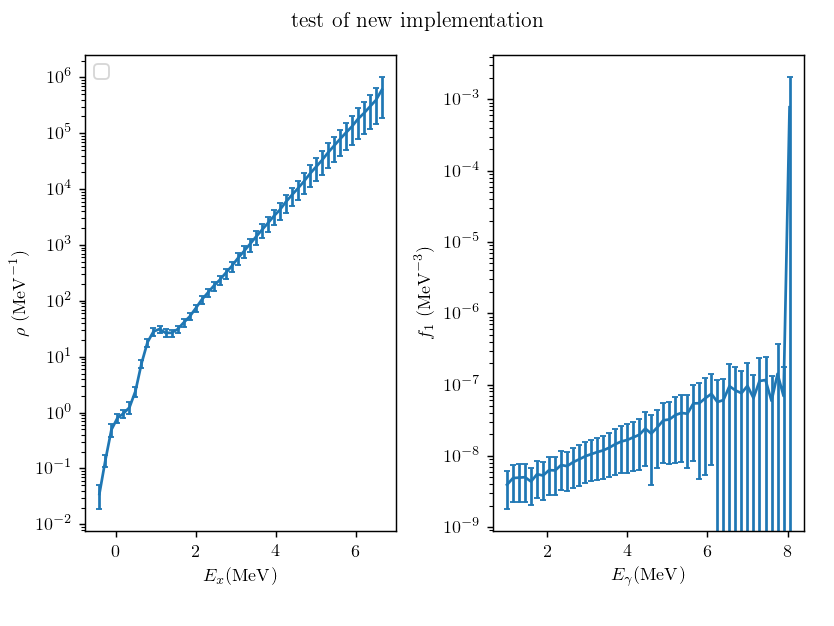

[]

In [28]:
fig, ax1, ax2 = nld_gsf_plot(title="test of new implementation")
ax1.errorbar(rho_ens_initialMeV[0].E, nld_mean[:,0], yerr=nld_mean[:,1])
ax2.errorbar(gsf_ens_initialMeV[0].E, gsf_mean[:,0], yerr=gsf_mean[:,1])
plt.plot()


# REST BELOW HERE CURRENTLY Might NOT WORK!

## A) Normalize NLD and GSF sequentially

#### 1) Normalize ensemble mean with uncertainty

<IPython.core.display.Javascript object>


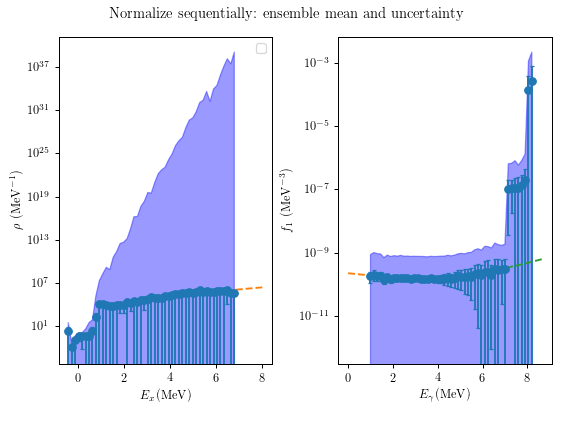

In [21]:
title = "Normalize sequentially: ensemble mean and uncertainty"
fig, ax1, ax2 = nld_gsf_plot(title=title)

gsf_ext_low = normGSF_mean.gsf_ext_low
gsf_ext_high = normGSF_mean.gsf_ext_high
gsf_fit = normGSF_mean.gsf

ax1.errorbar(rho_fit[:,0],rho_fit[:,1],
             yerr=rho_fit[:,1]*std_rel_nld["fit"],
             fmt="o",
             label=r"ompy results, normalized")
ax1.fill_between(rho_fit[:,0], 
                 rho_fit[:,1] - rho_fit[:,2], 
                 rho_fit[:,1] + rho_fit[:,2],
                 color='blue', alpha=0.4,
                 label="unc. including normalization")
ax1.plot(nld_ext[:,0],nld_ext[:,1],"--")

ax2.errorbar(gsf_fit[:,0],gsf_fit[:,1],
             yerr=gsf_fit[:,1]*std_rel_gsf["fit"],
             fmt="o")
ax2.fill_between(gsf_fit[:,0], 
                 gsf_fit[:,1] - gsf_fit[:,2], 
                 gsf_fit[:,1] + gsf_fit[:,2],
                 color='blue', alpha=0.4)
ax2.plot(gsf_ext_low[:,0],gsf_ext_low[:,1],"--")
ax2.plot(gsf_ext_high[:,0],gsf_ext_high[:,1],"--")


plt.savefig("figs/seq_ensemble_mean.pdf")
plt.show()

all_fits = dict()
all_fits["seq_mean"] = dict()
all_fits["seq_mean"]["rho_fit"] = rho_fit
all_fits["seq_mean"]["gsf_ext_low"] = normGSF_mean.gsf_ext_low
all_fits["seq_mean"]["gsf_ext_high"] = normGSF_mean.gsf_ext_high
all_fits["seq_mean"]["gsf"]= gsf_fit

#### 2) Normalize each ensembel member separately (no individ uncertainty)

<IPython.core.display.Javascript object>


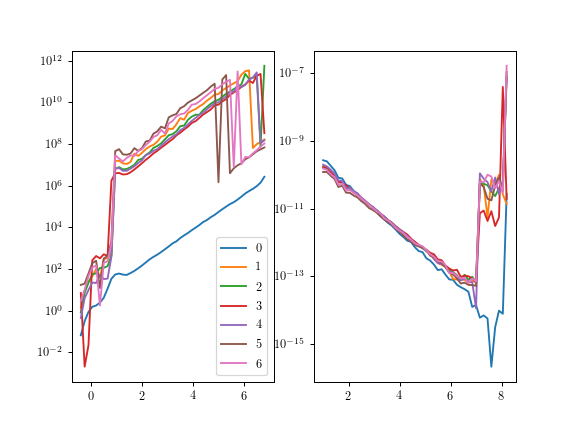

<IPython.core.display.Javascript object>


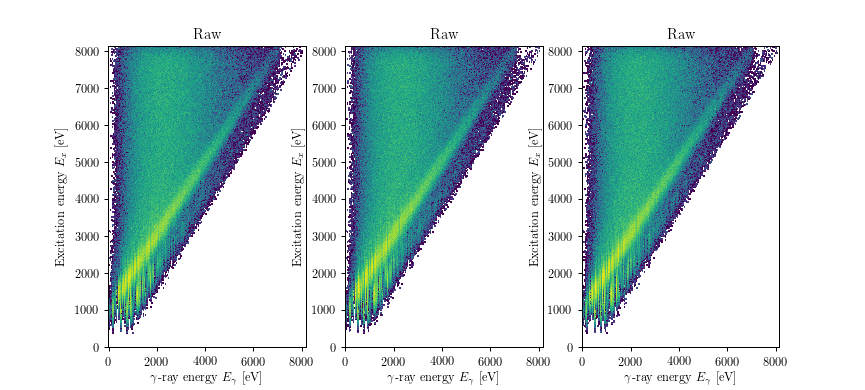

Start of iteration 0
Start of iteration 1
Start of iteration 2


In [30]:
fig, (ax1,ax2) = plt.subplots(1,2) 
for i in [0,1,2,3,4,5,6]:
    ax1.plot(rho_ens[i].E, rho_ens[i].values, "-", label=str(i))
    ax2.plot(gsf_ens[i].E, gsf_ens[i].values, "-")
ax1.set_yscale("log")
ax1.legend()
ax2.set_yscale("log")
plt.plot()

fig, axes = plt.subplots(1,3) 
for i in range(3):
    ax = axes[i]
    print("Start of iteration {}".format(i))
    mat = om.Matrix(ensemble[i],
                 Ex=firstgen.Ex,
                 Eg=firstgen.Eg)
    mat.plot(ax=ax)

In [ ]:
# normalize each nld and GSF separately
nlds = []
nld_exts = []
gsfs = []
N_fits_norm = 20
for i in range(N_fits_norm):
    print("\n Attempt iteration nr {}".format(i))
    nld = np.c_[rho_ens_initial[0].E*1e-3, rho_ens_initial[i].values, np.ones_like(rho_ens_initial[0].values)]
    
    # Bounds for differential evolution
    # A, alpha, T
    pnld_norm["bounds_diff_evo"] = [(1e-3, 100), # A
                                    (1e-1, 1e1), # alpha
                                    (0.1, 1), # T
                                    (D0[0]*0.99,D0[0]*1.01)] #D0

    normNLD = om.NormNLD(nld=nld,
                         method="find_norm", pnorm=pnld_norm,
                         nldModel="CT", pext=pnld_ext,
                         D0 = D0,
                         pspin=pspin,
                         fname_discretes=fname_discretes )

    rho_fit = normNLD.nld_norm
    nld_ext = normNLD.nld_ext
    A_norm = normNLD.A_norm
    alpha_norm = normNLD.alpha_norm
    discretes = normNLD.discretes
    multinest_samples = normNLD.multinest_samples

    nlds.append(rho_fit)
    nld_exts.append(nld_ext)
    
    gsf_fit = gsf_ens_initialMeV[i].values
    normGSF = norm_gsf_differnt_nld(rho_fit, gsf_fit, nld_ext, alpha_norm, D0, Gg=pspin["Gg"])
    
    gsf = normGSF.gsf
    gsfs.append(gsf)


 Attempt iteration nr 0
Result from find_norm / differential evolution:
      fun: 4.5021610698101835
     jac: array([ 1.15463195e-05,  5.86197757e-06, -3.28626015e-06,  1.40651490e-01])
 message: 'Optimization terminated successfully.'
    nfev: 2320
     nit: 36
 success: True
       x: array([0.39889974, 2.35287593, 0.61582367, 9.108     ])
/home/fabiobz/Desktop/Masterthesis/misc/oslo_method_python/notebooks/RAINIER/164Dy_fake

 Starting multinest: this may take a while. Check also terminal output
  analysing data from multinest/nld_norm_.txt
    A              0.51 +- 0.11
    alpha          2.21 +- 0.15
    T              0.566 +- 0.054
    D0             9.2062 +- 0.0058

 Attempt iteration nr 1
Result from find_norm / differential evolution:
      fun: 5745507845649.008
     jac: array([ 1.79278344e+14, -1.95312500e+05, -9.41037793e+11,  1.22549805e+10])
 message: 'Optimization terminated successfully.'
    nfev: 310
     nit: 1
 success: True
       x: array([1.00000000e-03, 

  return nld_Sn[0] - T * np.log(nld_Sn[1] * T)



Cube 3: 0.9999999999999999
pars: A: 0.001000026667376958, alpha: 1.2009875314421674, T: 1.07648238223003,D0: inf
D0: inf, nld_Sn : [7.658, 0.0]
0.0 1.07648238223003
Cube 3: 0.9999999999999999
pars: A: 0.0010000200385918458, alpha: 1.2009378376319655, T: 1.0766684109345936,D0: inf
D0: inf, nld_Sn : [7.658, 0.0]
0.0 1.0766684109345936
Cube 3: 0.9999999999999999
pars: A: 0.0010000187413173613, alpha: 1.2009417825637292, T: 1.0766812917377426,D0: inf
D0: inf, nld_Sn : [7.658, 0.0]
0.0 1.0766812917377426
Cube 3: 1.0
pars: A: 0.0010000200325127409, alpha: 1.2009881898638464, T: 1.0766040027056178,D0: inf
D0: inf, nld_Sn : [7.658, 0.0]
0.0 1.0766040027056178
Cube 3: 1.0
pars: A: 0.0010000218550583625, alpha: 1.2009915809256557, T: 1.0766555225047574,D0: inf
D0: inf, nld_Sn : [7.658, 0.0]
0.0 1.0766555225047574
Cube 3: 1.0
pars: A: 0.001000021173911193, alpha: 1.2009952770073202, T: 1.0766178868742151,D0: inf
D0: inf, nld_Sn : [7.658, 0.0]
0.0 1.0766178868742151
Cube 3: 1.0
pars: A: 0.00100002

ERROR: Interrupt received: Terminating


In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2) 
for i in range(N_fits_norm):
    ax1.semilogy(nlds[i][:,0],nlds[i][:,1], alpha=0.05*i+0.2)
    ax1.semilogy(nld_exts[i][:,0],nld_exts[i][:,1], alpha=0.05*i+0.2)
    ax2.semilogy(gsfs[i][:,0],gsfs[i][:,1], alpha=0.05*i)

i=0
nld = np.c_[rho_ens_initial[0].E*1e-3, rho_ens_initial[i].values, np.ones_like(rho_ens_initial[0].values)]
nldSn = normNLD.nldSn_from_D0(D0, pspin["Sn"], pspin["J_target"],
                      spincutModel=pspin["spincutModel"], spincutPars=pspin["spincutPars"])
ax1.errorbar(nldSn[0],nldSn[1][0],yerr=D0[1]/D0[0]*nldSn[1][0], fmt="ro")

ax1.plot(discretes[:,0], discretes[:,1],"r")

plt.show()

In [ ]:
# plots for normalization of each combination separately
nlds_arr = np.array(nlds)
gsfs_arr = np.array(gsfs)

rho_mean = np.mean(nlds_arr[:,:,1], axis=0)
gsf_mean = np.mean(gsfs_arr[:,:,1], axis=0)

rho_std = np.std(nlds_arr[:,:,1], axis=0)
gsf_std = np.std(gsfs_arr[:,:,1], axis=0)

rho_fit = np.c_[rho_ens[0].E, 
                rho_mean, 
                rho_std]
gsf_fit = np.c_[gsf_ens[0].E, 
                gsf_mean, 
                gsf_std]


def plot_points_band(ax1, ax2, rho_fit, gsf_fit):
    ax1.plot(rho_fit[:,0], 
                 rho_fit[:,1],
                 "o",
                 label=r"ompy results, normalized")
    ax1.fill_between(rho_fit[:,0], 
                     rho_fit[:,1] - rho_fit[:,2], 
                     rho_fit[:,1] + rho_fit[:,2],
                     color='blue', alpha=0.4,
                     label="uncertainty")

    ax2.plot(gsf_fit[:,0], 
                 gsf_fit[:,1],
                 "o")
    ax2.fill_between(gsf_fit[:,0], 
                 gsf_fit[:,1] - gsf_fit[:,2], 
                 gsf_fit[:,1] + gsf_fit[:,2],
                     color='blue', alpha=0.4)


title = "Normalize each ensembel member separately (no individ uncertainty)"
fig, ax1, ax2 = nld_gsf_plot(title=title)


plot_points_band(ax1, ax2, rho_fit, gsf_fit)
# ax1.plot(nld_ext[:,0],nld_ext[:,1],"--")
# ax2.plot(gsf_ext_low[:,0],gsf_ext_low[:,1],"--")
# ax2.plot(gsf_ext_high[:,0],gsf_ext_high[:,1],"--")


plt.savefig("figs/seq_each_member.pdf")
plt.show()

all_fits["seq_each_member"] = dict()
all_fits["seq_each_member"]["rho_fit"] = rho_fit
all_fits["seq_each_member"]["gsf_ext_low"] = normGSF_mean.gsf_ext_low
all_fits["seq_each_member"]["gsf_ext_high"] = normGSF_mean.gsf_ext_high
all_fits["seq_each_member"]["gsf"]= gsf_fit

#### 2) Normalize each ensembel member separately (but with uncertainty from enseble)
this is somewhat contradictory, but it why not try. Why contradict? -> I normalize each memeber separatly because I assume that I should not have a valid ensemble uncertainty in the degenerate room

In [ ]:
# normalize each nld and GSF separately -- but with uncertainties from ensemble
nlds = []
nld_exts = []
gsfs = []
for i in range(N_fits_norm):
    print("\n Attempt iteration nr {}".format(i))
    nld = np.c_[rho_ens_initial[0].E*1e-3, rho_ens_initial[i].values, rho_initial_std]
    
    # Bounds for differential evolution
    # A, alpha, T
    pnld_norm["bounds_diff_evo"] = [(1e-3, 100), # A
                                    (1e-1, 1e1), # alpha
                                    (0.1, 1), # T
                                    (D0[0]*0.99,D0[0]*1.01)] #D0

    normNLD = om.NormNLD(nld=nld,
                         method="find_norm", pnorm=pnld_norm,
                         nldModel="CT", pext=pnld_ext,
                         D0 = D0,
                         pspin=pspin,
                         fname_discretes=fname_discretes )

    rho_fit = normNLD.nld_norm
    nld_ext = normNLD.nld_ext
    A_norm = normNLD.A_norm
    alpha_norm = normNLD.alpha_norm
    discretes = normNLD.discretes
    multinest_samples = normNLD.multinest_samples

    nlds.append(rho_fit)
    nld_exts.append(nld_ext)
    
    gsf_fit = gsf_ens_initialMeV[i].values
    normGSF = norm_gsf_differnt_nld(rho_fit, gsf_fit, nld_ext, alpha_norm, D0, Gg=pspin["Gg"])
    
    gsf = normGSF.gsf
    gsfs.append(gsf)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2) 
for i in range(N_fits_norm):
    ax1.semilogy(nlds[i][:,0],nlds[i][:,1], alpha=0.05*i)
    ax2.semilogy(gsfs[i][:,0],gsfs[i][:,1], alpha=0.05*i)
plt.show()

In [ ]:
# plots for normalization of each combination separately
nlds_arr = np.array(nlds)
gsfs_arr = np.array(gsfs)

rho_mean = np.mean(nlds_arr[:,:,1], axis=0)
gsf_mean = np.mean(gsfs_arr[:,:,1], axis=0)

rho_std = np.std(nlds_arr[:,:,1], axis=0)
gsf_std = np.std(gsfs_arr[:,:,1], axis=0)

####

rho_fit = np.c_[rho_ens[0].E, 
                rho_mean, 
                rho_std]
gsf_fit = np.c_[gsf_ens[0].E, 
                gsf_mean, 
                gsf_std]

title = "Normalize each ensemble member separately (but take ensemble uncertainty after fit)"
fig, ax1, ax2 = nld_gsf_plot(title=title)

plot_points_band(ax1, ax2, rho_fit, gsf_fit)
# ax1.plot(nld_ext[:,0],nld_ext[:,1],"--")
# ax2.plot(gsf_ext_low[:,0],gsf_ext_low[:,1],"--")
# ax2.plot(gsf_ext_high[:,0],gsf_ext_high[:,1],"--")

plt.savefig("figs/seq_each_member_sic_but_uncertainty.pdf")
plt.show()

all_fits["seq_each_member_sic_w_unc"] = dict()
all_fits["seq_each_member_sic_w_unc"]["rho_fit"] = rho_fit
all_fits["seq_each_member_sic_w_unc"]["gsf_ext_low"] = normGSF_mean.gsf_ext_low
all_fits["seq_each_member_sic_w_unc"]["gsf_ext_high"] = normGSF_mean.gsf_ext_high
all_fits["seq_each_member_sic_w_unc"]["gsf"]= gsf_fit

### B) Normalize NLD and GSF simultaneously
#### 1) Norm ensemble mean with uncertainty

In [ ]:
gsf_fit = normGSF_mean.gsf

chi2_args = normNLD.chi2_args
pext_nld = normNLD.pext

rho_mean = np.mean([vec.values for vec in rho_ens_initialMeV], axis=0)
gsf_mean = np.mean([vec.values for vec in gsf_ens_initialMeV], axis=0)
rho_std = np.std([vec.values for vec in rho_ens_initialMeV], axis=0)
gsf_std = np.std([vec.values for vec in gsf_ens_initialMeV], axis=0)

nld = np.c_[rho_fit[:,0],rho_mean,rho_std]
gsf = np.c_[gsf_fit[:,0],gsf_mean,gsf_std]
gsf_ext_low = normGSF_mean.gsf_ext_low
gsf_ext_high = normGSF_mean.gsf_ext_high
sigma_integral_rel = integral_unc_rel
Gg = pspin["Gg"]
nldModel="CT"

args = (normGSF_mean, nld, chi2_args, pext_nld, nldModel,
        gsf, gsf_ext_low, gsf_ext_high,
        sigma_integral_rel, Gg)

object_fun = normGSF_mean.chi2_nld_gsf

bounds = np.array([(0.1, 10), # A
             (0.5, 3), # alpha
             (0.4, 0.7), # T
             (D0[0]*0.98,D0[0]*1.02), #D0 -- need to keep fixed for diff evo
             (norm*1e-1,norm*1e1)]) #B

popt_simultan, multinest_samples_simultan = normGSF_mean.normalize_nld_gsf_simultan(args,bounds,D0)

In [18]:
nld_samples_sim, gsf_samples_sim = om.tranform_nld_gsf(multinest_samples_simultan, 
                                                    rho_ens_initialMeV,
                                                    gsf_ens_initialMeV)

rho_mean = np.mean([vec.values for vec in nld_samples_sim], axis=0)
gsf_mean = np.mean([vec.values for vec in gsf_samples_sim], axis=0)

rho_std = np.std([vec.values for vec in nld_samples_sim], axis=0)
gsf_std = np.std([vec.values for vec in gsf_samples_sim], axis=0)

####

rho_fit = np.c_[rho_ens[0].E, 
                rho_mean, 
                rho_std]
gsf_fit = np.c_[gsf_ens[0].E, 
                gsf_mean, 
                gsf_std]

title = "Simultaneous normalization -- -- ensemble mean with uncertainty"

ax1.errorbar(rho_ens[0].E,
             rho_mean,
             yerr=rho_mean*std_rel_nld["fit"],
             fmt="o",
             label=r"ompy results, normalized")

ax2.errorbar(gsf_ens[0].E, 
             gsf_mean,
             yerr=gsf_mean*std_rel_gsf["fit"],
             fmt="o")

fig, ax1, ax2 = nld_gsf_plot(title=title)



plot_points_band(ax1, ax2, rho_fit, gsf_fit)
# ax1.plot(nld_ext[:,0],nld_ext[:,1],"--")
# ax2.plot(gsf_ext_low[:,0],gsf_ext_low[:,1],"--")
# ax2.plot(gsf_ext_high[:,0],gsf_ext_high[:,1],"--")


plt.savefig("figs/simultan_mean.pdf")
plt.show()

all_fits["sim_mean"] = dict()
all_fits["sim_mean"]["rho_fit"] = rho_fit
all_fits["sim_mean"]["gsf_ext_low"] = normGSF_mean.gsf_ext_low
all_fits["sim_mean"]["gsf_ext_high"] = normGSF_mean.gsf_ext_high
all_fits["sim_mean"]["gsf"]= gsf_fit

NameError: name 'multinest_samples_simultan' is not defined

In [29]:
# normalize each ensemble member separately


 Attempt iteration nr 0


NameError: name 'gsf_fit' is not defined

In [ ]:
nlds_arr = np.array(nld_samples_sims)
gsfs_arr = np.array(gsf_samples_sims)

nlds_arr = nlds_arr.reshape(nlds_arr.shape[:-3] + (-1, len(rho_ens[0].E)))
gsfs_arr = gsfs_arr.reshape(gsfs_arr.shape[:-3] + (-1, len(gsf_ens[0].E)))

rho_mean = np.mean(nlds_arr, axis=0)
gsf_mean = np.mean(gsfs_arr, axis=0)

rho_std = np.std(nlds_arr, axis=0)
gsf_std = np.std(gsfs_arr, axis=0)

####

rho_fit = np.c_[rho_ens[0].E, 
                rho_mean, 
                rho_std]
gsf_fit = np.c_[gsf_ens[0].E, 
                gsf_mean, 
                gsf_std]

title = "Simultaneous normalization -- each ensemble member seperately (no uncertainty)"
fig, ax1, ax2 = nld_gsf_plot(title=title)

plot_points_band(ax1, ax2, rho_fit, gsf_fit)
# ax1.plot(nld_ext[:,0],nld_ext[:,1],"--")
# ax2.plot(gsf_ext_low[:,0],gsf_ext_low[:,1],"--")
# ax2.plot(gsf_ext_high[:,0],gsf_ext_high[:,1],"--")

plt.savefig("figs/simultan_each_member.pdf")
plt.show()

all_fits["sim_each_member"] = dict()
all_fits["sim_each_member"]["rho_fit"] = rho_fit
all_fits["sim_each_member"]["gsf_ext_low"] = normGSF_mean.gsf_ext_low
all_fits["sim_each_member"]["gsf_ext_high"] = normGSF_mean.gsf_ext_high
all_fits["sim_each_member"]["gsf"]= gsf_fit

###############
fig, ax = plt.subplots()
for i in range(100):
    plt.semilogy(gsf_fit[:,0], gsfs_arr[i],"o")
#     plt.semilogy(gsf_fit[:,0], gsfs_arr[i,:]-gsf_std, "--")
    plt.show()

# print(gsf_fit[-5:-2,:])
print(gsf_fit[-5:-1,1], gsf_std[-5:-1])
print(gsf_fit[-5:-1,1]- gsf_std[-5:-1])

# fig, ax = plt.subplots()
# ax.plot(gsfs_arr[:,-2])
# plt.show()
print(gsfs_arr[:,-4].mean())
print(gsfs_arr[:,-4].std())

print(gsfs_arr[:,-3].mean())
print(gsfs_arr[:,-3].std())

In [ ]:
for key, value in all_fits.items():
    print(key)
    mean_err = np.mean(value["rho_fit"][:,2] / value["rho_fit"][:,1])
    print(mean_err)
    mean_err = np.mean(value["gsf"][:,2] / value["gsf"][:,1])
    print(mean_err, "\n")

fig, ax1 = plt.subplots()
# gsf = all_fits["sim_mean"]["gsf"]
# ax1.semilogy(gsf[:,0],gsf[:,1])

# gsf = all_fits["sim_each_member"]["gsf"]
# ax1.plot(gsf[:,0],gsf[:,1])

gsf = all_fits["sim_mean"]["gsf"]
ax1.semilogy(gsf[:,0],gsf[:,2]/gsf[:,1], "b")

gsf = all_fits["sim_each_member"]["gsf"]
ax1.plot(gsf[:,0],gsf[:,2]/gsf[:,1], "k")


# gsf = all_fits["seq_mean"]["gsf"]
# ax1.plot(gsf[:,0],gsf[:,2], "b")

# gsf = all_fits["each_member"]["gsf"]
# ax1.plot(gsf[:,0],gsf[:,2], "k")